## Task 2
Flow shop

In [ ]:
## libraries
import numpy as np
import pandas as pd
#from gurobipy import *
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from glob import glob
import time

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## initila parameters
a = 16807
b = 127773
c = 2836
m = 2**31 - 1

### jobs and machines
mi = 20    # machines
nj = 500   # jobs

In [ ]:
## parameters of local search
Sn = 20  ## neighborhood size
MaxIt = 5 ## maximum iterations without improve

In [ ]:
## seed of instances
SS = [1368624604, 450181436, 1927888393, 1759567256, 606425239, 19268348, 1298201670, 2041736264, 379756761, 28837162]
## seed
Xo = SS[0]

In [ ]:
## procedure to create random numbers
def ale(Xo):
    k = int(Xo/b)
    Xi = a*(Xo % b) - k*c
    if (Xi < 0):
        Xi = Xi + m
    return Xi

In [ ]:
## instances creation
def inst_crea(Seed):
    lt1 = {}
    Xi = Seed
    for i in range(mi):
        for j in range(nj):
            Xi = ale(Xi)
            Ui = Xi/m
            dij = int(1 + Ui*(99-1+1))
            lt1[i,j]=dij
    #print(lt)
    #pd.Series(lt).unstack(fill_value=0).to_csv('newfile.csv', mode='a', index=False)
    #pd.Series(lt).unstack(fill_value=0)
    return(lt1)

In [ ]:
inst_crea(1368624604)

In [ ]:
insp = inst_crea(873654221)

In [ ]:
DFins = pd.DataFrame(insp, index = range(1))
DFins = DFins.stack(level=0)
DFins

In [ ]:
destination = "/content/drive/MyDrive/Colab Notebooks/Metaheuristics/Instancias Task II/Verifica" + str(1) + ".csv"
destination
DFins.to_csv(destination)

In [ ]:
for i in SS:
  inst_crea(i)
  DFins = pd.DataFrame(inst_crea(i), index = range(1))
  DFins = DFins.stack(level=0)
  destination = "/content/drive/MyDrive/Colab Notebooks/Metaheuristics/Instancias Task II/Verifica" + str(i) + ".csv"
  DFins.to_csv(destination)

### Begin to procedure

In [ ]:
## vector of machiens
Mo = [j for j in range(mi)]

In [ ]:
## codification
## initial solution
Xs = [i for i in range(nj)]
#Xs

In [ ]:
def FObjective (Xr, Mm1, lt1):
## procedure receive current solution, list of machines, and times matrix
## return objective function, initail times matrix and final times matrix
    
    ## objective function
    ## parameters
    ## initial times for each job in each machine
    ITij = {}
    ## initial times for each job in each machine
    FTij = {}
    ## machine 1
    acu = 0
    for i in Xr:
        ITij[0,i] = acu
        FTij[0,i] = acu + lt1[0,i]
        acu = acu + lt1[0,i]

    # other machines
    for j in Mm1[1:]:
        acu = 0
        for i in Xr:
            ITij[j,i] = max(FTij[j-1,i],acu)
            FTij[j,i] = ITij[j,i] + lt1[j,i]
            acu = ITij[j,i] + lt1[j,i]

    #print(pd.Series(ITij).unstack(fill_value=0))
    #print(pd.Series(FTij).unstack(fill_value=0))

    ## objective function
    FO = max(FTij.values())
    
    return(FO, FTij, ITij)

In [ ]:
### OPTION 1
# operator to neighbor
## swap
def swap(Xri, Snn):
## receive current solution and size of neighborhood
## return neighborhood
    
    ## creation of neighborhood
    Ln = [] ## list of neighbors
    for k in range(Snn):
        # copy for creating one neighbor
        Xr = Xri.copy()
        # select a job 1 random
        R1 = np.random.randint(len(Xr))
        # select a job 2 random
        R2 = np.random.randint(len(Xr))
        ## swap
        tep = Xr[R1]
        Xr[R1] = Xr[R2]
        Xr[R2] = tep
        # store the new neighbor
        Ln.append(Xr)
    
    return(Ln)

In [ ]:
## OPTION 2
## operator break solution and second part reverse
def invert(Xri, Snn):

    Ln = [] ## list of neighbors
    for k in range(Snn):

        Xr = Xri.copy()
        ## break solution for R1
        R1 = np.random.randint(len(Xr))
        ## first part of vector
        #print(Xr[:R1])
        ## second part reverse of vector
        ## first take second part of list, and second [] reverse vector
        #print(Xr[R1:][::-1])
        # new vector
        if np.random.randint(2) == 0:
          Xr = Xr[:R1] +Xr[R1:][::-1]  
        else:
          Xr = Xr[:R1][::-1] +Xr[R1:]

        # store the new neighbor
        Ln.append(Xr)

    #Ln
    return(Ln)

In [ ]:
#invert(Xs, Sn)

### Local search
Receive problem and multple instances

In [ ]:
##3 complete procedure

## procedure to receive 
# Xx initial solutions
# Mm list of machines
# lts times

def LocalSearch(Xx, Mm, lts):

    Evl = [] ## list with behavior solution

    h = 0 ## iterations
    g = 0 ## iterations with inversion operator

    while h < MaxIt:
        ## initial solution
        Rta = FObjective(Xx, Mm, lts)
        Cur = Rta[0]  # store the current solution
        #print(Cur)
        
        if (h > MaxIt/2): ## if iterations is 
          ## create neighborhood OPTION 1
          Ng = swap(Xx, Sn)
        else:
          ## create neighborhood OPTION 2
          Ng = invert(Xx, Sn)

        ## evaluate neigborhood
        FNg = []
        for k in Ng:
            Rtai = FObjective(k, Mm, lts)
            FNg.append(Rtai[0])

        ## select the best solution
        minS = min(FNg)
        ## if new solution is better than initial, remplace if not current solution keeps
        if minS < Cur:
            h = 0
            minpos = FNg.index(minS)
            Xx = Ng[minpos]
        else:
            h = h + 1

        #print('best solution')
        Evl.append(minS)
    #print(minS)
    #print(Xs)
    ## return the best or final solution, behavior of solution
    return(minS, Evl)

In [ ]:
### initial solutions
SS = [1368624604, 450181436, 1927888393, 1759567256, 606425239, 19268348, 1298201670, 2041736264, 379756761, 28837162]
#Mo = [j for j in range(mi)]
#for p in SS:
#  Xo = p
#  lt = inst_crea(Xo) ##create times
#  Rta = FObjective(Xs, Mo, lt)
#  print(Rta[0])

### Complete algorithm to use experiment design

In [ ]:
%%time
## running several instances

### parameters to calibrate
#NSn = [50, 30, 20, 5] ## options to size neighbor
Sn = 20  ## neighborhood size

#NMaxIt = [20, 10, 5, 3, 2, 1] ## options to maximum iterations
MaxIt = 5 ## maximum iterations without improve

#Instances
## seed of instances
SS = [1368624604, 450181436, 1927888393, 1759567256, 606425239, 19268348, 1298201670, 2041736264, 379756761, 28837162]
#SS = [1368624604] 
#Xo = SS[0] ## seed


## Initial instance
Xs = [i for i in range(nj)] ## initial solution
Mo = [j for j in range(mi)]

## dictionary where will be stored all iterations
Dic_exp = {}
Dic_tim = {} 
r = 0

## for for evaluate different cases
for p in SS:  

## for evaluate maximum iterations
#for p in NSn:  


    #Sn = p ## neighbothood Size
    
    #MaxIt = p ## maximum iterations without stop
    
    Xo = p ## seed
    ## creation iteration
    lt = inst_crea(Xo) ##create times

    #print('iteration', Xo)
    # iterations
    List_sol = []
    List_tim = []
    for v in range(30): ## replications
        
        ## initial time
        to = time.time()
        
        ## call local search
        Sv = LocalSearch(Xs, Mo, lt)
        
        ## store best solution in the case
        List_sol.append(Sv[0]) # objective function solution
        List_tim.append(time.time() - to) 
        
        #print(Sv[0])
        #print(time.time() - to)
        print(v)
    
    ## Add solutions of iterations in dictionary
    Dic_exp[r] = List_sol
    Dic_tim[r] = List_tim
    r = r + 1

#print(Dic_exp)
## show answers
df1 = pd.DataFrame(Dic_exp)#, columns = NMaxIt)
df2 = pd.DataFrame(Dic_tim)#, columns = NMaxIt)
Sv[1] #last solution behavior    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
CPU times: user 3h 31min 27s, sys: 42.5 s, total: 3h 32min 9s
Wall time: 3h 32min 49s


[29988,
 30014,
 29982,
 30038,
 29982,
 29969,
 29909,
 29956,
 29909,
 29890,
 29842,
 29801,
 29828,
 29933,
 29911,
 29788,
 29817,
 29905,
 29872,
 29771,
 29771,
 29864,
 29856,
 29688,
 29729,
 29715,
 29688,
 29666,
 29765,
 29666,
 29794,
 29611,
 29657,
 29711,
 29611,
 29592,
 29592,
 29592,
 29592,
 29561,
 29517,
 29517,
 29517,
 29517,
 29505,
 29505,
 29550,
 29615,
 29474,
 29552,
 29474,
 29597,
 29453,
 29488,
 29453,
 29553,
 29425,
 29516,
 29469,
 29425,
 29424,
 29431,
 29495,
 29459,
 29409,
 29488,
 29416,
 29504,
 29388,
 29534,
 29456,
 29388,
 29338,
 29539,
 29455,
 29345,
 29303,
 29303,
 29298,
 29298,
 29327,
 29345,
 29285,
 29292,
 29334,
 29285,
 29261,
 29326,
 29429,
 29342,
 29241,
 29383,
 29248,
 29346,
 29208,
 29306,
 29307,
 29254,
 29208,
 29201,
 29201,
 29278,
 29258,
 29168,
 29260,
 29195,
 29168,
 29106,
 29130,
 29260,
 29189,
 29106,
 29090,
 29182,
 29246,
 29236,
 29077,
 29077,
 29148,
 29175,
 29072,
 29072,
 29096,
 29260,
 29048,


In [ ]:
df1.columns = SS
df1

,1368624604,450181436,1927888393,1759567256,606425239,19268348,1298201670,2041736264,379756761,28837162
0,28598,29113,28649,29197,28783,28972,29018,28907,28522,28423
1,28531,29243,28761,28977,29013,29259,28727,29055,28691,28806
2,28765,28641,28781,28720,29475,28984,28782,29050,28536,28990
3,28713,29167,28999,29177,28490,29372,29053,29155,28739,28697
4,28484,28923,28808,28360,28848,29275,29002,28388,28664,29335
5,28153,29143,28553,28657,28683,29300,28902,29034,29002,28978
6,28267,29033,28789,28771,28915,29058,28851,29384,28673,28885
7,28406,28828,28940,28876,29020,29458,28950,29033,28763,29458
8,28760,29038,28635,28568,28415,28770,28591,28906,28353,28783
9,28446,28800,28619,28898,28274,29119,28743,29024,28538,28929


In [ ]:
df2.columns = SS
df2

,1368624604,450181436,1927888393,1759567256,606425239,19268348,1298201670,2041736264,379756761,28837162
0,28.196467,31.359085,56.628183,15.859462,35.434211,52.495074,33.741922,54.403222,30.771179,61.377922
1,42.460738,22.244972,46.083432,33.962379,29.033246,39.580511,49.342915,43.974494,29.089999,33.870356
2,28.532499,66.904158,43.413675,46.478027,9.799428,51.455544,51.526159,27.309151,42.533720,38.548675
3,30.582156,29.524589,38.627350,13.730244,44.214966,32.074063,27.681301,50.162005,24.331871,59.551574
4,46.116580,43.021487,42.305501,62.975856,37.167243,37.323018,33.997540,76.172324,26.786911,22.433252
5,51.037105,29.124543,49.983590,42.097140,38.141906,36.027980,36.956655,42.710738,13.658060,29.455141
6,70.296603,39.444102,41.793218,35.977173,40.763978,44.371353,35.647477,17.278970,35.999347,37.554572
7,45.911791,57.911125,38.303791,31.437931,21.024832,27.503603,29.644860,37.591424,19.028892,14.628661
8,29.705199,39.006339,57.506382,58.457085,59.041292,74.278538,55.251703,32.757843,50.670388,50.354787
9,49.271916,57.217567,52.350990,36.994834,68.869171,38.765380,53.143053,40.964167,45.741785,42.469453


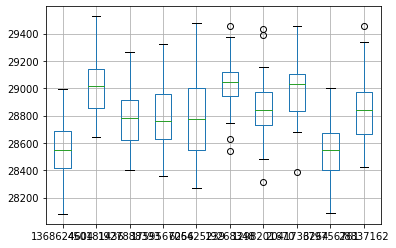

In [ ]:
boxplot = df1.boxplot()  

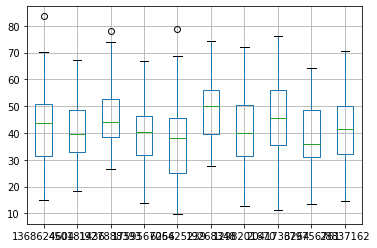

In [ ]:
boxplot = df2.boxplot()  

In [ ]:
df1.to_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/perfor_opeMX.csv')

In [ ]:
df2.to_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/Time_opeMx.csv')

In [ ]:
%%time
plt.plot(Sv[1])

### Data - Graphics

In [ ]:
## Desempeño instancias con operador 1
Data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/perfor_ope1.csv', index_col=[0])
#RR = Data1.boxplot()
Data1.describe()

,1368624604,450181436,1927888393,1759567256,606425239,19268348,1298201670,2041736264,379756761,28837162
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,28150.066667,28660.633333,28383.100000,28334.666667,28318.500000,28604.400000,28406.066667,28598.400000,28239.100000,28436.400000
std,238.347028,282.353347,193.232993,206.172899,241.279027,248.576998,226.193834,232.856416,256.539619,235.524155
min,27631.000000,28170.000000,28039.000000,27951.000000,27852.000000,28273.000000,28038.000000,28208.000000,27831.000000,28041.000000
25%,27999.250000,28487.000000,28244.250000,28205.750000,28145.750000,28475.000000,28211.750000,28425.000000,28072.750000,28252.500000
50%,28116.000000,28681.000000,28382.500000,28314.500000,28299.500000,28594.500000,28422.500000,28532.500000,28181.000000,28412.000000
75%,28277.000000,28786.750000,28482.500000,28459.500000,28474.000000,28681.250000,28548.000000,28753.000000,28378.000000,28560.250000
max,28602.000000,29280.000000,28909.000000,28772.000000,28819.000000,29406.000000,28888.000000,29173.000000,28807.000000,28925.000000


In [ ]:
## Desempeño instancias con operador 2
Data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/perfor_ope2.csv', index_col=[0])
Data2.describe()

,1368624604,450181436,1927888393,1759567256,606425239,19268348,1298201670,2041736264,379756761,28837162
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000
mean,29440.333333,29911.566667,29839.733333,29571.700000,29547.633333,30116.70000,29723.166667,29829.766667,29333.700000,29771.700000
std,122.136536,114.781857,144.374736,89.570296,115.590682,98.11153,98.012696,158.113596,108.192087,131.348484
min,29198.000000,29643.000000,29568.000000,29368.000000,29325.000000,29811.00000,29557.000000,29568.000000,29148.000000,29414.000000
25%,29365.250000,29853.750000,29725.750000,29493.500000,29478.250000,30071.25000,29670.250000,29721.250000,29253.250000,29703.500000
50%,29465.500000,29924.500000,29858.500000,29580.000000,29522.500000,30124.50000,29709.500000,29806.000000,29306.000000,29776.000000
75%,29503.500000,29990.500000,29920.500000,29642.250000,29616.000000,30169.50000,29781.500000,29922.750000,29415.250000,29868.500000
max,29673.000000,30141.000000,30120.000000,29784.000000,29872.000000,30315.00000,29917.000000,30175.000000,29566.000000,30032.000000


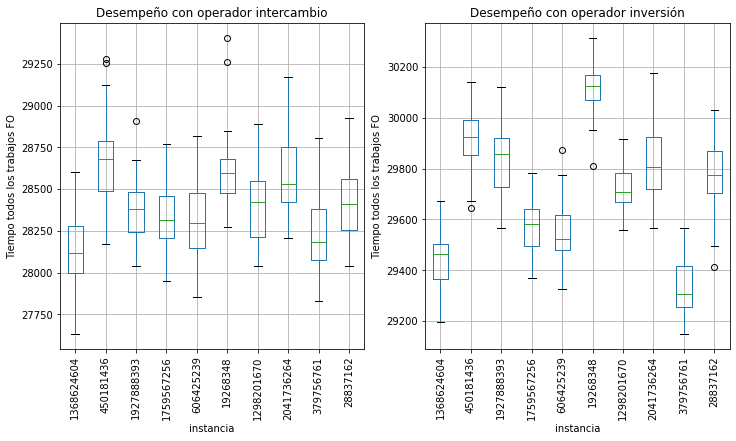

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
Data1.boxplot()
plt.xticks(rotation ='vertical')
plt.ylabel("Tiempo todos los trabajos FO")
plt.xlabel("instancia")
plt.title("Desempeño con operador intercambio")

plt.subplot(1, 2, 2)
Data2.boxplot()
plt.xticks(rotation ='vertical')
plt.ylabel("Tiempo todos los trabajos FO")
plt.xlabel("instancia")
plt.title("Desempeño con operador inversión")


plt.show()

In [ ]:
## Tiempos de corrida con operador 1
Data3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/Time_ope1.csv', index_col=[0])
#Data3.boxplot()

In [ ]:
# Tiempos de corrida con operador 2
Data4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/Time_ope2.csv', index_col=[0])
#Data4.boxplot()

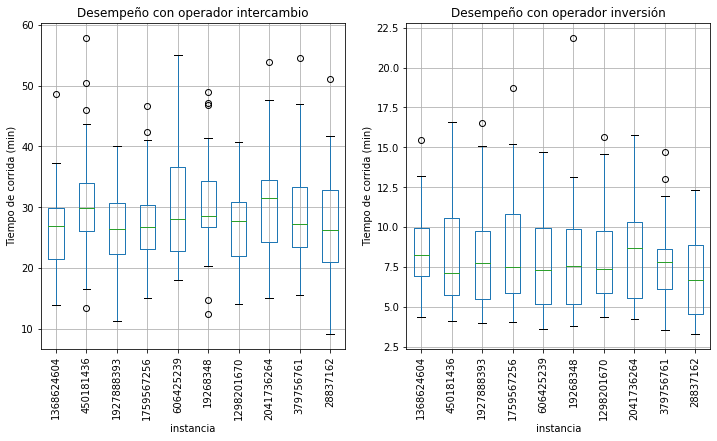

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
Data3.boxplot()
plt.xticks(rotation ='vertical')
plt.ylabel("Tiempo de corrida (min)")
plt.xlabel("instancia")
plt.title("Desempeño con operador intercambio")

plt.subplot(1, 2, 2)
Data4.boxplot()
plt.xticks(rotation ='vertical')
plt.ylabel("Tiempo de corrida (min)")
plt.xlabel("instancia")
plt.title("Desempeño con operador inversión")


plt.show()

In [ ]:
# Desempeño con diferentes iteraciones
Data5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/perfor_Maxit.csv', index_col=[0])
#Data5.boxplot()

In [ ]:
# Tiempo con diferentes máximo de iteraciones
Data7 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/Time_Maxit.csv', index_col=[0])
#Data7.boxplot()

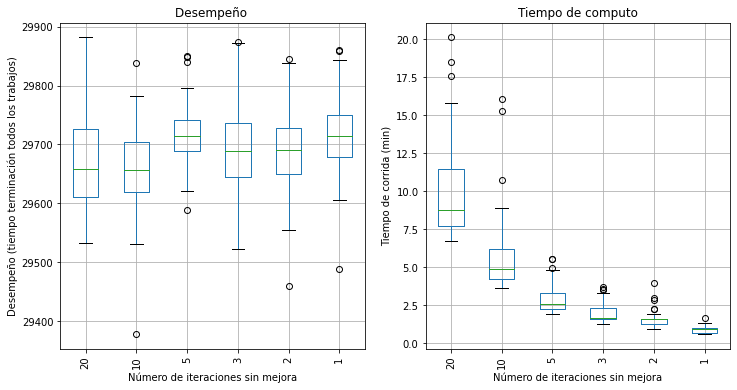

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
Data5.boxplot()
plt.xticks(rotation ='vertical')
plt.ylabel("Desempeño (tiempo terminación todos los trabajos)")
plt.xlabel("Número de iteraciones sin mejora")
plt.title("Desempeño ")

plt.subplot(1, 2, 2)
Data7.boxplot()
plt.xticks(rotation ='vertical')
plt.ylabel("Tiempo de corrida (min)")
plt.xlabel("Número de iteraciones sin mejora")
plt.title("Tiempo de computo")


plt.show()

In [ ]:
# Desempeño con diferentes tamaños de vecindario
Data6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/perfor_SizeN.csv', index_col=[0])
#Data6.boxplot()

In [ ]:
# Tiempo con diferentes tamaños de vecindario
Data8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/Time_SizeN.csv', index_col=[0])
#Data8.boxplot()


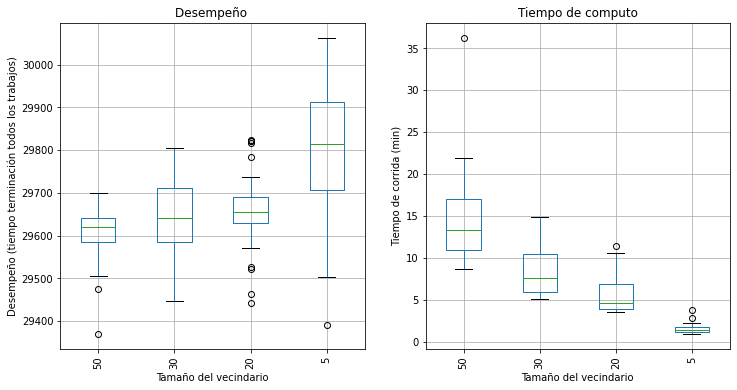

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
Data6.boxplot()
plt.xticks(rotation ='vertical')
plt.ylabel("Desempeño (tiempo terminación todos los trabajos)")
plt.xlabel("Tamaño del vecindario")
plt.title("Desempeño ")

plt.subplot(1, 2, 2)
Data8.boxplot()
plt.xticks(rotation ='vertical')
plt.ylabel("Tiempo de corrida (min)")
plt.xlabel("Tamaño del vecindario")
plt.title("Tiempo de computo")


plt.show()

In [ ]:
# Desempeño con mezlca de operadores
Data10 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Metaheuristics/perfor_opeMX.csv', index_col=[0])
Data10.describe()

,1368624604,450181436,1927888393,1759567256,606425239,19268348,1298201670,2041736264,379756761,28837162
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,28541.733333,29001.600000,28789.800000,28797.866667,28785.866667,29036.766667,28853.100000,28989.400000,28540.400000,28850.733333
std,231.925365,192.768505,204.652843,237.564181,284.951022,205.953072,244.158845,224.104748,201.200638,246.127936
min,28081.000000,28641.000000,28405.000000,28360.000000,28274.000000,28542.000000,28318.000000,28388.000000,28088.000000,28423.000000
25%,28416.000000,28854.750000,28623.000000,28629.250000,28552.000000,28944.250000,28731.000000,28837.500000,28401.000000,28664.000000
50%,28546.000000,29017.500000,28785.000000,28761.500000,28775.000000,29047.500000,28842.500000,29028.000000,28547.000000,28838.000000
75%,28687.000000,29139.250000,28914.500000,28957.250000,29004.000000,29119.000000,28975.500000,29107.750000,28671.500000,28972.250000
max,28998.000000,29527.000000,29267.000000,29322.000000,29475.000000,29458.000000,29432.000000,29459.000000,29002.000000,29458.000000


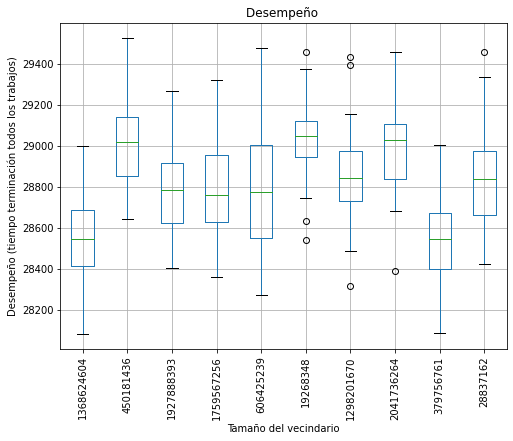

In [ ]:
fig, axes = plt.subplots(figsize=(8, 6))

#plt.subplot(1, 2, 1)
Data10.boxplot()
plt.xticks(rotation ='vertical')
plt.ylabel("Desempeño (tiempo terminación todos los trabajos)")
plt.xlabel("Tamaño del vecindario")
plt.title("Desempeño ")


plt.show()